# Lecture 16: PID Controller

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//suann124/AIinTeaching/blob/main/pid_controller.ipynb)

## **Why PID Control?**

In any **standard feedback control system**, three realities always appear:

1. **We have a goal** – the reference input *r(t)* tells us where we want to be.  
2. **We face disruptions** – disturbances act directly on the plant, pushing it off course.  
3. **We see through an imperfect lens** – sensors add noise, so our measurements are never exact.  

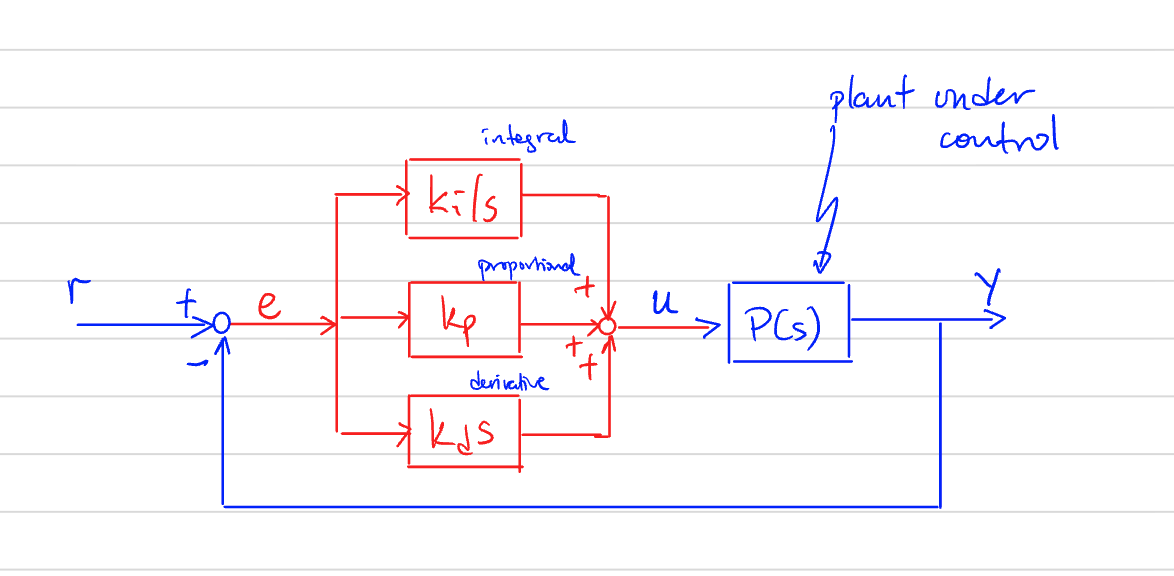

### 1. $r$ sets the target (reference input)  
- The signal $r(t)$ represents what we want the system to do.  
- It could be a constant (e.g., “hold the temperature at 25°C”), or a time-varying trajectory (e.g., “make the drone follow this flight path”).  
- This is the *command* to the system, and the whole point of the controller is to make the output $y(t)$ follow this reference.  



### 2. $y$ is the achieved result (plant output)  
- The signal $y(t)$ is what the plant actually produces in response to the control input $u(t)$.  
- In real systems, $y(t)$ may lag behind $r(t)$, overshoot it, or never reach it due to limitations, disturbances, or modeling errors.  
- This is the only “truth” we can observe about the system’s performance — if $y(t)$ doesn’t match $r(t)$, we know correction is needed.  


### 3. $e = r - y$ tells us the gap (error signal)  
- The error signal $e(t)$ quantifies how far the system is from its target:  
  $$
  e(t) = r(t) - y(t)
  $$  
- A positive error means the output is below the desired value, while a negative error means the output has overshot.  
- The PID controller takes this error as its *input*, continuously computing corrections that drive the error toward zero.  
- In other words: **no error → no control action.**  


In the feedback loop:  
- $r$ is the **goal**,  
- $y$ is the **reality**,  
- $e = r - y$ is the **gap** the controller works to close.  


The **PID controller** gives us a powerful, yet simple, way to respond:

- **Proportional (P):** Pushes against error immediately, keeping the system from drifting away.  
- **Integral (I):** Eliminates steady-state error, guaranteeing that the output will eventually track the reference exactly, even under constant disturbances.  
- **Derivative (D):** Anticipates error trends, adding stability and damping so the system avoids overshoot and oscillations.  

**In short, PID empowers us to:**

- 🎯 **Track** the reference accurately,  
- 🛡️ **Reject** the influence of disturbances, and  
- ⚖️ **Stay robust** despite sensor noise and modeling uncertainty.  

This is why PID is the most widely used controller in engineering practice:  
**it balances simplicity, intuition, and effectiveness to tame real-world systems.**


The error signal is defined as  

$$
e(t) = r(t) - y(t)
$$

The PID control law is  

$$
u(t) = K_p e(t)
      + K_i \int_{0}^{t} e(\tau)\, d\tau
      + K_d \frac{de(t)}{dt}
$$

- **Proportional term**: $K_p e(t)$  
- **Integral term**: $K_i \int_{0}^{t} e(\tau)\, d\tau$  
- **Derivative term**: $K_d \tfrac{de(t)}{dt}$  

The corresponding transfer function from error $e$ to control input $u$ is  

$$
C(s) = K_p + \frac{K_i}{s} + K_d s
$$

## **Time-Domain Interpretation of P, I, and D Terms**


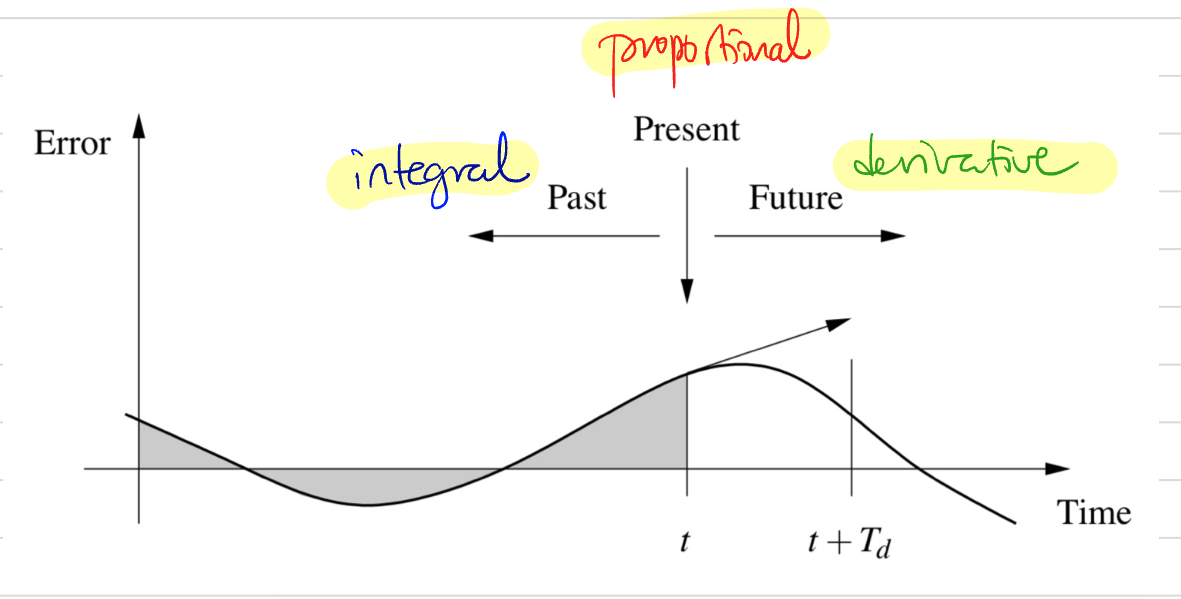

### 1. **Proportional term (present)**
- Reacts to the **instantaneous error** at the current time $t$.  
- The vertical arrow at “Present” indicates that the proportional term depends only on the current value of the error.  
- A larger error produces a proportionally larger control action.

$$
u_P(t) = K_p \, e(t)
$$

### 2. **Integral term (past)**
- Accumulates the error **over the past history up to time $t$**.  
- The shaded area under the curve represents the cumulative effect of error.  
- Ensures that persistent error is eliminated, driving the steady-state error to zero.

$$
u_I(t) = K_i \int_0^t e(\tau)\, d\tau
$$

### 3. **Derivative term (future)**
- Predicts how the error will **evolve into the future** by looking at its slope at time $t$.  
- In the figure, the tangent at $t$ projects forward to $t+T_d$, showing the “look-ahead” effect.  
- Provides damping: a rapid change in error triggers a strong corrective action.

$$
u_D(t) = K_d \frac{de(t)}{dt}
$$

### **Key Takeaway**
- **Proportional**: reacts to the error *now*.  
- **Integral**: accumulates error from the *past*.  
- **Derivative**: anticipates the error trend into the *future*.  

Together, PID control leverages **history, present information, and prediction** to compute effective control actions.

## **Closed-Loop Transfer Function with a PID Controller**
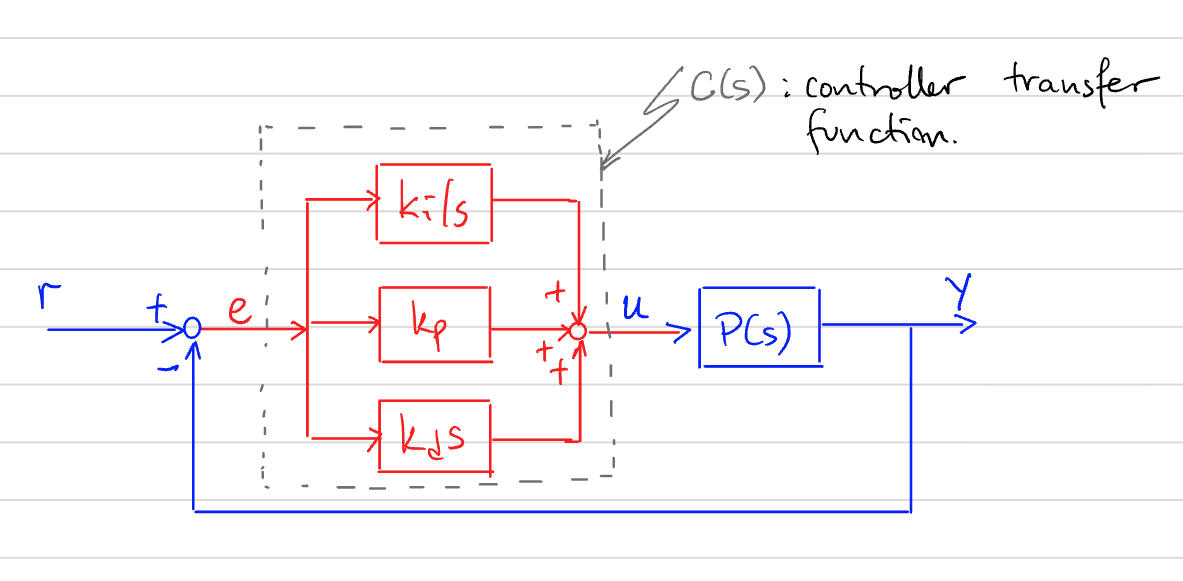

### 1. The Plant $P(s)$
- The **plant** is the system we want to control (e.g., motor, pendulum, UAV, thermal chamber).  
- In the Laplace domain, it is represented by its **transfer function**:

$$
P(s) = \frac{Y(s)}{U(s)}
$$

where  
- $U(s)$ = Laplace transform of the control input $u(t)$,  
- $Y(s)$ = Laplace transform of the plant output $y(t)$.  

Thus, $P(s)$ describes how the plant transforms an input signal into an output signal.

**Examples:**
- First-order system (thermal system, RC circuit):  
  $$
  P(s) = \frac{1}{\tau s + 1}
  $$
- Second-order system (mass–spring–damper, motor model):  
  $$
  P(s) = \frac{1}{Ms^2 + Bs + K}
  $$
- Underdamped 2nd-order example (natural frequency $\omega_n$, damping ratio $\zeta$):  
  $$
  P(s) = \frac{\omega_n^2}{s^2 + 2\zeta \omega_n s + \omega_n^2}
  $$


### 2. The Controller $C(s)$
- The **controller** processes the error signal $e(t) = r(t) - y(t)$ and generates the control input $u(t)$.  
- For a PID controller:

$$
C(s) = K_p + \frac{K_i}{s} + K_d s
$$

where $K_p$, $K_i$, $K_d$ are the proportional, integral, and derivative gains.


### 3. Closed-Loop Transfer Function $G_{ry}(s)$
- In a **unity feedback loop**, the transfer function from the reference $r(s)$ to the output $y(s)$ is:

$$
G_{ry}(s) = \frac{P(s)C(s)}{1 + P(s)C(s)}
$$

- **Numerator ($P(s)C(s)$):** represents the forward path dynamics (controller × plant).  
- **Denominator ($1+P(s)C(s)$):** accounts for the effect of feedback.  

This formula fully characterizes how the output $y$ responds to the reference $r$.


### 4. DC Gain
- The **DC gain** of a transfer function $H(s)$ is defined as:

$$
H(0) = \lim_{s \to 0} H(s)
$$

- Physically: it is the ratio of output to input **at steady state** when the input is a constant (step input).  
- Example: if $H(s) = \tfrac{1}{s+2}$, then $H(0) = \tfrac{1}{2}$. A unit step input will settle to 0.5 in steady state.


### 5. Stability
- A linear time-invariant (LTI) system is **stable** if its impulse response remains bounded for bounded inputs.  
- In transfer function terms:
  - The poles of $H(s)$ (roots of the denominator) must have **negative real parts** (i.e., lie in the left half of the $s$-plane).  
  - If poles lie in the right half-plane or on the imaginary axis (without damping), the system is unstable or marginally stable.  


### 6. Steady-State Tracking
- For a **stable system**, the steady-state output under a unit step input is given by the DC gain:

$$
y_{ss} = H(0)
$$

- Applied to the closed-loop transfer function:

$$
y_{ss} = G_{ry}(0)
$$

- Interpretation:
  - If $G_{ry}(0) = 1$, the system tracks a step perfectly (zero steady-state error).  
  - If $G_{ry}(0) < 1$, the system has a nonzero steady-state error.  
  - If $G_{ry}(0) > 1$, the system overshoots the desired step in steady state.

## **Proportional-Only Feedback Control**

Consider the PID controller with no integral and no derivative action:

$$
K_i = 0, \quad K_d = 0
$$

Then the controller reduces to **pure proportional control**:

$$
C(s) = K_p
$$

<br>

### **Steady-State Output for a Unit Step**
The closed-loop transfer function from the reference $r(s)$ to the output $y(s)$ is:

$$
G_{ry}(s) = \frac{C(s)P(s)}{1 + C(s)P(s)}
$$

For a unit step input, the steady-state output is given by the **DC gain** of the closed-loop system:

$$
y_{ss} = G_{ry}(0) \cdot 1
$$

<br>

### **Substituting Proportional Controller**
Since $C(s) = K_p$, we have:

$$
C(0) = K_p
$$

So the steady-state output becomes:

$$
y_{ss} = \frac{K_p P(0)}{1 + K_p P(0)}
$$

$K_p$ can be adjusted to make $y_{ss}$ as close to 1 as possible.

<br>

### **Steady-State Error**
The steady-state error is defined as:

$$
e_{ss} = 1 - y_{ss}
$$

Substituting the formula for $y_{ss}$:

$$
e_{ss} = 1 - \frac{K_p P(0)}{1 + K_p P(0)} = \frac{1}{1 + K_p P(0)}
$$

<br>

---

### **Interpretation**
- $y_{ss}$ and $e_{ss}$ depend on both the plant’s DC gain $P(0)$ and the proportional gain $K_p$.  
- Increasing $K_p$ makes $e_{ss}$ smaller, so the system tracks better.  
- As $K_p \to \infty$, $e_{ss} \to 0$, but **in practice large $K_p$ can cause oscillations or instability**.  
- Pure proportional control can only **reduce** steady-state error, not eliminate it completely.  
- To guarantee zero steady-state error, integral action ($K_i > 0$) is required.

---

✅ **Key takeaway**:  
- $y_{ss} = \dfrac{K_p P(0)}{1 + K_p P(0)}$  
- $e_{ss} = \dfrac{1}{1 + K_p P(0)}$  
- Larger $K_p$ reduces $e_{ss}$, but integral control is needed to drive it exactly to zero.

## **Examples**

### **Example 1: With P-term only**

Consider the plant:
$$
P(s) = \frac{1}{(s+1)^3}.
$$

We apply **pure proportional control** with $C(s) = k_p$.

---

### Step Responses

- For different values of $k_p$ (e.g., $k_p = 1, 2, 5$),  
  we compare the closed-loop **step response** $y(t)$ and the corresponding **control input** $u(t)$.

---

📌 **Observations**:
- Increasing $k_p$:
  - reduces the steady-state error
  - but introduces larger oscillations and overshoot

This demonstrates the trade-off of proportional control:  
you can reduce error, but stability margins worsen as $k_p$ increases.


In [ ]:
# @title Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
!pip install -q control
!pip install -q ipywidgets
from control.matlab import *
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
# @title Plant: underdamped second-order system
wn = 2.0  # natural frequency
zeta = 0.1  # damping ratio
num_p = [wn**2]
den_p = [1, 2*zeta*wn, wn**2]
Gp = signal.TransferFunction(num_p, den_p)

# Time vector
t = np.linspace(0, 8, 800)

def multiply_tf(tf1, tf2):
    """Multiply two transfer functions manually"""
    # (n1/d1) * (n2/d2) = (n1*n2)/(d1*d2)
    num = np.polymul(tf1.num, tf2.num)
    den = np.polymul(tf1.den, tf2.den)
    return signal.TransferFunction(num, den)

def closed_loop_tf(Gc, Gp):
    """Calculate closed-loop transfer function T = GcGp/(1+GcGp)"""
    # First multiply Gc * Gp
    GcGp = multiply_tf(Gc, Gp)

    # T = GcGp / (1 + GcGp)
    # This means T = GcGp.num / (GcGp.den + GcGp.num)
    num_cl = GcGp.num
    den_cl = np.polyadd(GcGp.den, GcGp.num)

    return signal.TransferFunction(num_cl, den_cl)

print(f"Plant: {Gp}")

Plant: TransferFunctionContinuous(
array([4.]),
array([1. , 0.4, 4. ]),
dt: None
)


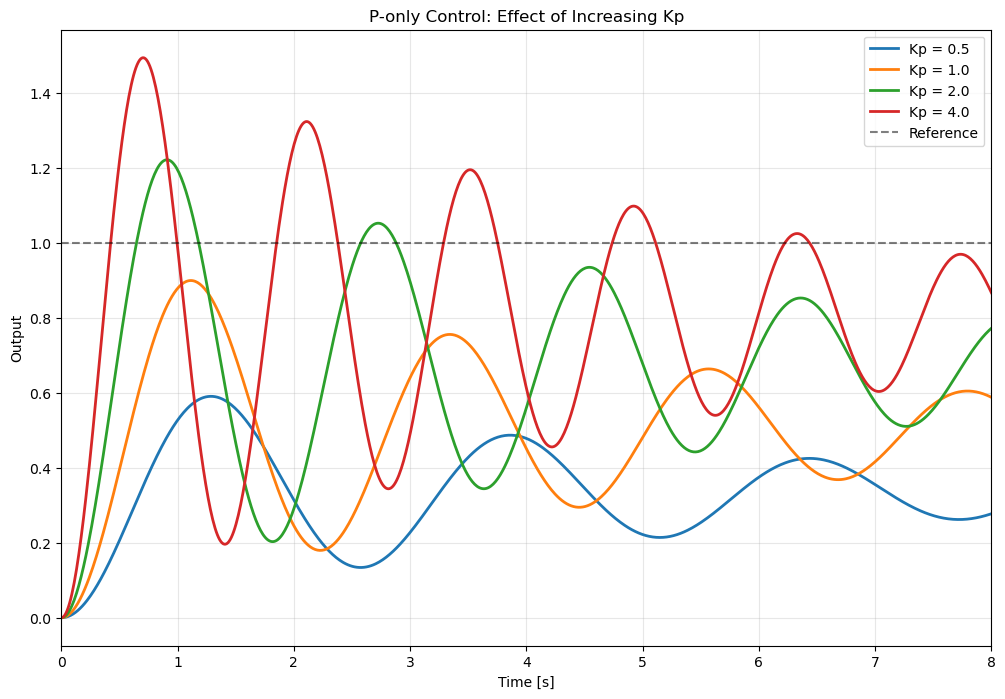

Steady-state values (should be 1.0 for perfect tracking):
Kp = 0.5: SS value = 0.278, SS error = 0.722
Kp = 1.0: SS value = 0.588, SS error = 0.412
Kp = 2.0: SS value = 0.773, SS error = 0.227
Kp = 4.0: SS value = 0.868, SS error = 0.132

🔍 Observations:
• Higher Kp → faster response but more overshoot
• Steady-state error remains (P-only cannot eliminate it for step inputs)
• Too high Kp → system becomes oscillatory/unstable


In [ ]:
# Test different Kp values
Kp_values = [0.5, 1.0, 2.0, 4.0]
plt.figure(figsize=(12, 8))

for i, Kp in enumerate(Kp_values):
    # P-only controller
    Gc = signal.TransferFunction([Kp], [1])

    # Closed-loop transfer function T(s) = GcGp/(1+GcGp)
    T_cl = closed_loop_tf(Gc, Gp)

    # Step response
    t_step, y_step = signal.step(T_cl, T=t)

    plt.plot(t_step, y_step, label=f'Kp = {Kp}', linewidth=2)

plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Reference')
plt.xlabel('Time [s]')
plt.ylabel('Output')
plt.title('P-only Control: Effect of Increasing Kp')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 8)
plt.show()

# Show steady-state error for each case
print("Steady-state values (should be 1.0 for perfect tracking):")
for Kp in Kp_values:
    Gc = signal.TransferFunction([Kp], [1])
    T_cl = closed_loop_tf(Gc, Gp)
    _, y_step = signal.step(T_cl, T=t)
    ss_value = y_step[-1]
    ss_error = 1.0 - ss_value
    print(f"Kp = {Kp}: SS value = {ss_value:.3f}, SS error = {ss_error:.3f}")

print("\n🔍 Observations:")
print("• Higher Kp → faster response but more overshoot")
print("• Steady-state error remains (P-only cannot eliminate it for step inputs)")
print("• Too high Kp → system becomes oscillatory/unstable")

### Example 2: Proportional + Integral Control (PI)

Same plant as before:
$$
P(s) = \frac{1}{(s+1)^3},
$$

with proportional + integral control:
$$
C(s) = k_p + \frac{k_i}{s}, \quad k_p = 2.
$$

---

### Observations

- Zero $k_i \;\;\Rightarrow$ non-zero steady-state error  
- Nonzero $k_i \;\;\Rightarrow$ zero steady-state error  
- As $k_i$ increases:
  - the approach to steady-state output is faster
  - but the system becomes more oscillatory

In [ ]:
# Plant: P(s) = 1 / (s+1)^3
num = [1]
den = [1, 3, 3, 1]
P = tf(num, den)

def pi_demo(ki=0.0):
    kp = 2.0  # fixed

    # PI controller: C(s) = kp + ki/s
    C = tf([kp, ki], [1, 0])

    # Closed-loop system
    sys_cl = feedback(C*P, 1)

    # Step response
    t = np.linspace(0, 50, 800)
    y, t = step(sys_cl, T=t)

    # Error and control input
    e = 1 - y  # since r = 1
    # Control input u = kp*e + ki ∫e dt (simulate integral with cumulative sum)
    u = kp*e + ki*np.cumsum(e)*(t[1]-t[0])

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    # Step response y(t)
    ax1.plot(t, y, label=f"$k_i={ki:.2f}$")
    ax1.axhline(1, color='r', linestyle='--')
    ax1.set_ylim([0, 1.5])
    ax1.set_title("Step Response y(t)")
    ax1.set_xlabel("t")
    ax1.set_ylabel("y")
    ax1.grid(True)
    ax1.legend()

    # Control input u(t)
    ax2.plot(t, u, label=f"$k_i={ki:.2f}$")
    ax2.axhline(0, color='r', linestyle='--')
    ax2.set_ylim([-1, 3])
    ax2.set_title("Control Input u(t)")
    ax2.set_xlabel("t")
    ax2.set_ylabel("u")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Slider for ki
# interact(pi_demo, ki=(0.0, 2.0, 0.1))

## Example 3: Adding the Derivative Term

Now include derivative action in the controller:
$$
C(s) = k_p + \frac{k_i}{s} + k_d s.
$$

We check the closed-loop response under a **unit step reference input**.

---

### Fixed Parameters
- $k_p = 2.5$
- $k_i = 1.5$

We vary $k_d$.

---

📌 **Observation**:
- As $k_d$ increases, the closed-loop system becomes **more damped**
- Overshoot decreases
- Oscillations are reduced


In [ ]:
# Plant: P(s) = 1 / (s+1)^3
num = [1]
den = [1, 3, 3, 1]
P = tf(num, den)

def pid_demo(kd=0.0):
    kp = 2.5
    ki = 1.5

    # PID controller: C(s) = kp + ki/s + kd*s
    C = tf([kd, kp, ki], [1, 0])

    # Closed-loop system
    sys_cl = feedback(C*P, 1)

    # Step response
    t = np.linspace(0, 20, 800)
    y, t = step(sys_cl, T=t)

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(t, y, label=f"$k_d={kd:.2f}$")
    plt.axhline(1, color='r', linestyle='--')
    plt.ylim([0, 1.8])
    plt.title("Step Response y(t) with PID Control")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

# Slider for kd
# interact(pid_demo, kd=(0.0, 5.0, 0.1))
